# 네이버 영화평 감상분석

In [5]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm

In [6]:
train_df = pd.read_table('./data/ratings_train.txt')
test_df = pd.read_table('./data/ratings_test.txt')

In [7]:
train_df.shape, test_df.shape

((150000, 3), (50000, 3))

데이터 전처리

In [8]:
train_df['document'].nunique()

146182

In [9]:
# 중복이 있다면 중복 제거
train_df.drop_duplicates(subset=['document'], inplace=True)
train_df.shape

(146183, 3)

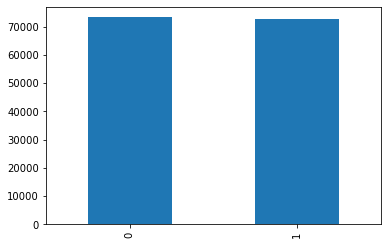

In [10]:
# 긍정, 부정 레이블 값의 분포
train_df.label.value_counts().plot(kind='bar')
plt.show()

In [11]:
train_df.label.value_counts()

0    73342
1    72841
Name: label, dtype: int64

In [12]:
train_df.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [13]:
train_df = train_df.dropna(how = 'any')
train_df.shape

(146182, 3)

In [14]:
test_df['document'].nunique()

49157

In [15]:
# 중복이 있다면 중복 제거
test_df.drop_duplicates(subset=['document'], inplace=True)
test_df.shape

(49158, 3)

In [16]:
# null값 제거
test_df = test_df.dropna(how = 'any')
test_df.shape

(49157, 3)

텍스트 전처리

In [17]:
# 트레인 셋
train_df['document'] = train_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_df.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [18]:
# 빈 데이터를 nan값으로
train_df['document'].replace('', np.nan, inplace=True)
train_df.isnull().sum()

id            0
document    391
label         0
dtype: int64

In [19]:
# null값 
train_df = train_df.dropna(how = 'any')
train_df.shape

(145791, 3)

In [20]:
# 전처리된 csv
train_df.to_csv('./data/movie_train.tsv', sep = '\t')


In [21]:
# 테스트 셋
test_df['document'] = test_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_df['document'].replace('', np.nan, inplace=True)
test_df.isnull().sum()


id            0
document    162
label         0
dtype: int64

In [22]:
# null값 
test_df = test_df.dropna(how = 'any')
test_df.shape

(48995, 3)

In [23]:
test_df.to_csv('./data/movie_test.tsv', sep = '\t')

토큰화

In [24]:
from konlpy.tag import Okt
okt = Okt()

In [25]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [26]:
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔')

['와', '이런', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만드는', '게', '나을', '뻔']

In [27]:
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [28]:
X_train = []
for sentence in tqdm(train_df['document']):
    morphs = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = ' '.join([word for word in morphs if not word in stopwords]) # 불용어 제거
    X_train.append(temp_X)

100%|██████████| 145791/145791 [11:04<00:00, 219.43it/s]


In [29]:
X_test = []
for sentence in tqdm(test_df['document']):
    morphs = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = ' '.join([word for word in morphs if not word in stopwords]) # 불용어 제거
    X_test.append(temp_X)

100%|██████████| 48995/48995 [03:59<00:00, 204.44it/s]


In [30]:
y_train = train_df.label.values
y_test = test_df.label.values

데이터가 문자열이므로 CounterVectorizer로 숫자로 바꾼 다음 LogisticRegression 분류

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [32]:
cvect = CountVectorizer()
cvect.fit(X_train)
X_train_cvect = cvect.transform(X_train)
X_test_cvect = cvect.transform(X_test)

In [33]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train_cvect, y_train)
pred = lr_clf.predict(X_test_cvect)
accuracy_score(y_test, pred)

0.8261659352995203

실제 데이터

In [34]:
review = "진짜 개노잼이다... 1편이랑 같은 감독맞나?러닝타임도 길어서 개지루함 ㄹㅇ"

In [35]:
import re
review = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', review)
review

'진짜 개노잼이다 편이랑 같은 감독맞나러닝타임도 길어서 개지루함 ㄹㅇ'

In [36]:
review = okt.morphs(review, stem = True)

In [37]:
temp_X = ' '.join([word for word in review if not word in stopwords])
temp_X = [temp_X]
temp_X

['진짜 개 노잼 이다 편이 랑 같다 감독 맞다 러닝 타임 기다 개 지루함 ㄹㅇ']

In [38]:
review_cvect = cvect.transform(temp_X)

In [39]:
pred = lr_clf.predict(review_cvect)
# 0은 부정
pred[0]

0

In [40]:
review2 = "이런 사랑영화가 다시 나올 수 있을까?"
review2 = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', review2)
temp_X = ' '.join([word for word in review2 if not word in stopwords])
temp_X = [temp_X]
review_cvect = cvect.transform(temp_X)
pred = lr_clf.predict(review_cvect)
# 0은 부정
print(temp_X)
pred[0]

['런   사 랑 영 화   다 시   나 올   수   있 을 까']


0

In [41]:
# 리스트에 여러개 리뷰가 들어와 있을 때
reviews = ['진짜 개노잼이다... 1편이랑 같은 감독맞나?러닝타임도 길어서 개지루함 ㄹㅇ',"이런 사랑영화가 다시 나올 수 있을까?"]

In [42]:
reviews = list(map(lambda x: re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', x), reviews))
print(reviews)

['진짜 개노잼이다 편이랑 같은 감독맞나러닝타임도 길어서 개지루함 ㄹㅇ', '이런 사랑영화가 다시 나올 수 있을까']


In [43]:
review_list = []
for review in reviews:
    review = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', review)
    morphs = okt.morphs(review)
    tmp = ' '.join([word for word in review if not word in stopwords])
    review_list.append(tmp)

In [44]:
review_cvect = cvect.transform(review_list)
pred = lr_clf.predict(review_cvect)

In [45]:
# 둘 다 부정
pred

array([0, 0], dtype=int64)

최적 파라미터 찾기

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [47]:
pipeline = Pipeline([
    ('cvector', CountVectorizer()),
    ('lr_clf', LogisticRegression())
])
params = {
    'cvector__ngram_range': [(1,1),(1,2)],
    'cvector__max_df': [0.9, 0.95, 0.99],
    'lr_clf__C': [1, 3, 5]
}
grid_pipe = GridSearchCV(pipeline, param_grid=params, cv=3, verbose=1, scoring='accuracy')
grid_pipe.fit(X_train, y_train)
print(grid_pipe.best_params_, grid_pipe.best_score_ )

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 12.3min finished
{'cvector__max_df': 0.9, 'cvector__ngram_range': (1, 2), 'lr_clf__C': 1} 0.8411904712910948


In [51]:
pred = grid_pipe.predict(X_test)
acc = accuracy_score(y_test, pred)
print(f'cvector + lr_clf 정확도: {acc:.4f}')

cvector + lr_clf 정확도: 0.8466
